In [74]:
import pandas as pd
import numpy as np

In [76]:
df = pd.read_csv("data/data_visualization.csv", low_memory=False)

In [78]:
def optimize_dataframe(df):
    for col in df.select_dtypes(include=["float64"]).columns:
        df[col] = df[col].astype(np.float32)
    for col in df.select_dtypes(include=["int64"]).columns:
        df[col] = df[col].astype(np.int32)
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].astype("category")
    return df
df = optimize_dataframe(df)

In [80]:
# 마약 범죄 정의
narcotics_types = {"NARCOTICS", "OTHER NARCOTIC VIOLATION"}

# 타겟 변수 생성
df["is_narcotics"] = np.where(df["Primary Type"].isin(narcotics_types), 1, 0).astype(np.uint8)

In [110]:
# Unknown을 결측치로 변환
df["District"] = df["District"].replace('unknown', np.nan)
df["Ward"] = df["Ward"].replace('unknown', np.nan)

# int는 결측치를 가질 수 없어 float로 전환
df["District"] = df["District"].astype(np.float32)
df["Ward"] = df["Ward"].astype(np.float32)

In [114]:
# Community Area Code 이상치 제거
df = df[df['Community Area Code'] >= 1].reset_index(drop=True)

In [122]:
# category 타입을 float으로 변환
df['Y Coordinate'] = pd.to_numeric(df['Y Coordinate'], errors='coerce')

# 이상치 제거
df = df[df['Y Coordinate'] >= 10000]

In [126]:
# 분석과 예측에 불필요한 컬럼 제거
drop_cols = ["Case Number", "ID", "Latitude","Block", "Longitude", "Location", "Primary Type", "IUCR", "FBI Code", "Description"]
df = df.drop(columns=drop_cols)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6170813 entries, 0 to 6170812
Data columns (total 12 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Date                  category
 1   Location Description  category
 2   Arrest                bool    
 3   Domestic              bool    
 4   Beat                  int32   
 5   District              float32 
 6   Ward                  float32 
 7   X Coordinate          category
 8   Y Coordinate          category
 9   Year                  int32   
 10  Community Area Code   int32   
 11  is_narcotics          uint8   
dtypes: bool(2), category(4), float32(2), int32(3), uint8(1)
memory usage: 378.3 MB


In [128]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [130]:
X = df.drop(columns="is_narcotics").copy()
y = df["is_narcotics"]

In [132]:
# category 타입 인코딩
for col in X.select_dtypes(include='category').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

In [134]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 클래스 불균형 비율 계산
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# XGBoost 모델 정의
model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=4,
    tree_method='hist',
    scale_pos_weight=scale_pos_weight,
    verbosity=1
)

# 모델 학습
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

scale_pos_weight: 8.14
              precision    recall  f1-score   support

           0       1.00      0.87      0.93   1098947
           1       0.49      0.98      0.65    134559

    accuracy                           0.89   1233506
   macro avg       0.74      0.93      0.79   1233506
weighted avg       0.94      0.89      0.90   1233506



Class|Precision|Recall|F1-score|
|------|---|---|---|
|0 (비마약 범죄)|1.00|0.87|0.93|
|1 (마약 범죄)|0.49|0.98|0.65|
|Marco Average|0.74|0.93|0.79|
|Weighted Average|0.94|0.89|0.90|

Model|Accuracy(%)|Macro F1(%)|
|------|---|---|
|XGBoost|89|79|

- 현재 모델은 **마약 범죄**를 잘 잡아내는 데 집중한 상태 (recall=0.98), 하지만 정밀도(Precision)이 낮아서 (0.49) 잘못된 **양성 예측(FP)** 이 많은 상황

- 불균형 데이터이기 때문에 오탐(FP)을 줄이기 위해서 임계치를 조정해서 커스텀을 예측을 함

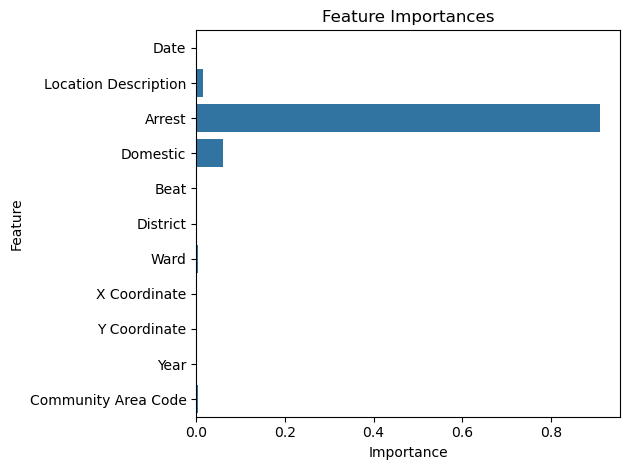

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
feature_names = X.columns

sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

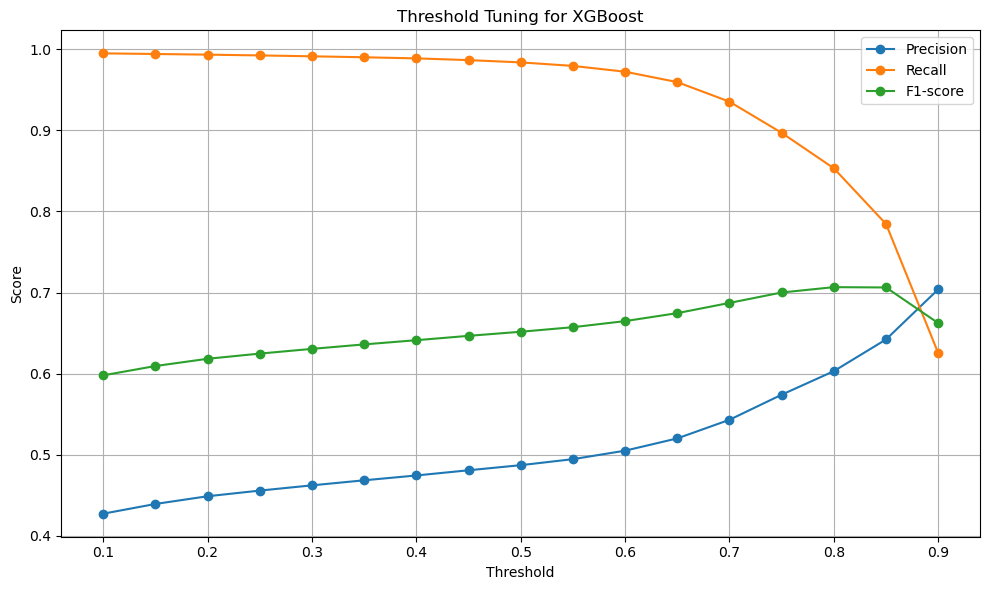

In [138]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# 예측 확률 (마약 클래스: 1에 대한 확률)
y_scores = model.predict_proba(X_test)[:, 1]

# 임계값 후보
thresholds = np.arange(0.1, 0.91, 0.05)

# 결과 저장
precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred_thresh = (y_scores >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1s, label='F1-score', marker='o')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning for XGBoost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- 재현율(Recall)이 너무 낮아지지 않는 선에서, 정밀도(Precision)과 F1-score가 최대가 되는 지점이 최적의 임계치(Threshold)이다

In [140]:
# 예측 확률 얻기
y_scores = model.predict_proba(X_test)[:, 1]

# 최적의 threshold로 커스텀 예측
optimal_threshold = 0.8
y_pred = (y_scores >= optimal_threshold).astype(int)

# 평가
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96   1098947
           1       0.60      0.85      0.71    134559

    accuracy                           0.92   1233506
   macro avg       0.79      0.89      0.83   1233506
weighted avg       0.94      0.92      0.93   1233506



Class|Precision|Recall|F1-score|
|------|---|---|---|
|0 (비마약 범죄)|0.98|0.93|0.96|
|1 (마약 범죄)|0.60|0.85|0.71|
|Marco Average|0.79|0.89|0.83|
|Weighted Average|0.94|0.92|0.93|

Model|Accuracy(%)|Macro F1(%)|
|------|---|---|
|XGBoost|92|83|